## Problem Set 6. Optimization methods. November 2015

### Makarova Anastasia
### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from numpy.matlib import repmat
import cvxpy as cvx
import gurobipy as grb


import scipy as sp
import scipy.optimize

import matplotlib.image as mpimg

## Problem 1

Implement the interior-point method for an inequality-constrained LP in 2
dimensions. You can assume that the problem is feasible, and in particular that (0,0) is feasible.
You can also assume that the feasible set is a compact (i.e. finite closed) polygon that lies within
[-1 1] x [-1 1]. Your code should plot the feasible set and the progress of the method towards
the optimum (to visualize the feasible polygon, you can use a dense mesh of points obtained by
the ndgrid on [-1 1] x [-1 1]). Try your method on several examples and submit three or four
visualizations that are the most interesting. Lite version (2 points): you can use fminunc to solve
the unconstrained subtasks.


### Solution

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & p^Tx \\
& s.t. 
& &  Ax \leq b
\end{aligned}
\end{equation*}

#### Barrier method:
* Input $$t = 1$$
* While $$||(f_k, f_{k+1})|| \geq \epsilon$$
* Loop 
$$
f_k = tp^Tx - \sum \log (b_i - a_ix) \\
x_k = argmin\ f_k \\
increase \ \ t = \mu t
$$




 
* We search for $x_k = argmin\ f_k$ using Newtone method 
$$ x_{k,j+1} = x_{k} - \alpha \frac{\frac{\partial f}{\partial x} (x_{kj})}{\frac{\partial^2 f}{\partial x^2}(x_{kj})}$$
$$ \frac{\partial f}{\partial x} = tp + \sum \frac{a_i}{b_i - a_ix}$$
$$\frac{\partial^2 f}{\partial x^2} =  \sum \frac{a^2_i}{(b_i - a_ix)^2} $$

* So, we need to create Jacobian and Hessian as we did in Pset4

In [59]:
class Newton():
    def __init__(self):
        self.epsilon = 1e-3
        self.gamma = 0.5
        
    def solve(self, f, x0, hessian, jacobian):
        
        regular = self.epsilon * np.ones(x0.shape[0])
        x_old = x0
        
        while True:
            
            param = 2
            x_new = x_old - self.gamma * jacobian(x_old).dot(np.linalg.inv(hessian(x_old) 
                                            + regular))

            while f(x_new) == np.inf:
                x_new = x_old - (self.gamma ** param) * jacobian(x_old).dot(np.linalg.inv(hessian(x_old) 
                                            + regular))
                param += 1

            if np.linalg.norm(x_new - x_old) < self.epsilon:
                break
                
            x_old = x_new
        return x_new

In [55]:
class InteriorPoint():
    
    def __init__(self):
        self.mu = 2
        self.epsilon = 1e-3
        self.x0 = np.array([0, 0]).T
        self.newton = Newton()
    
    def solve(self, p, A, b, callback = None):
        
        t = 1
        
        def fi(x):
            return A.dot(x) - b
        
        def f(x):
            return p.T.dot(x)
        
        def jacobian(t):
            def function(x):
                J = np.zeros(A.shape[1])
                for j in range(A.shape[1]):
                    J[j] = t * c[j] 
                    for i in range(A.shape[0]):
                        J[j] += A[i, j] / (b[i] - A[i].dot(x.T))
                return J
            return function
        
        def hessian():
            # H matrix 2x2
            def function(x):
                H = np.zeros((A.shape[1], A.shape[1]))
                for i in range(A.shape[0]):
                    H[0, 0] += A[i, 0] ** 2 / (A[i].dot(x.T) - b[i]) ** 2
                    H[1, 1] += A[i, 1] ** 2 / (A[i].dot(x.T) - b[i]) ** 2
                    H[0, 1] += A[i, 0] * A[i, 1] / (A[i].dot(x.T) - b[i]) ** 2
                    H[1, 0] += A[i, 0] * A[i, 1] / (A[i].dot(x.T) - b[i]) ** 2
                return H

            return function
        
        
        def barrier_function(t):
            
            def function(x):
                F = t * f(x)
                if (fi(x) > 0).any():
                    F = np.inf
                else:
                    F -= np.sum(np.log(-fi(x)))
                
                return F
            
            return function
        
        x_old = self.x0
        
        if callback:
            callback(x_old)
            
        while True:
            x_new = self.newton.solve(barrier_function(t), x_old, hessian(), jacobian(t))
            
            if np.linalg.norm(x_new - x_old) < self.epsilon:
                break

            if callback:
                callback(x_new)
                
            t = t * self.mu
            x_old = x_new
                
        return x_new

In [ ]:
x1_tr = []
x2_tr = []

def trajectory(x):
    x1_tr.append(x[0])
    x2_tr.append(x[1])

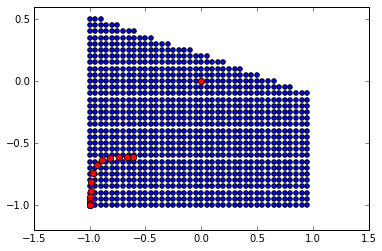

In [54]:
np.random.seed(2)

p = np.random.random(2)
A = np.random.random((4, 2))
b = np.random.random(4)
A = np.vstack((A, np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])))
b = np.hstack((b, np.array([1 ,1, 1, 1])))

solver = InteriorPoint()
X = solver.solve(p, A, b, trajectory)

plt.plot(x1_tr, x2_tr, 'ro')

x1, x2 = np.mgrid[-1:1:0.05, -1:1:0.05]
x1 = x1.reshape(-1)
x2 = x2.reshape(-1)

X1 = []
X2 = []

for i in range(x1.shape[0]):
    constraints = A.dot(np.array([x1[i], x2[i]])) - b
    if constraints[constraints > 0].any():
        continue
    else:
        X1.append(x1[i])
        X2.append(x2[i])

plt.scatter(X1, X2)

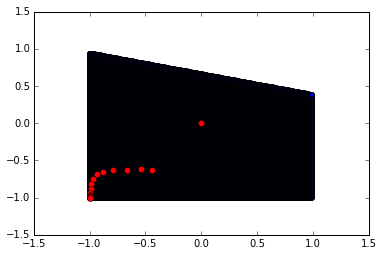

In [52]:
np.random.seed(155)

p = np.random.random(2)
A = np.random.random((4, 2))
b = np.random.random(4)
A = np.vstack((A, np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])))
b = np.hstack((b, np.array([1 ,1, 1, 1])))

solver = InteriorPoint()
X = solver.solve(p, A, b, trajectory)

plt.plot(x1_tr, x2_tr, 'ro')

x1, x2 = np.mgrid[-1:1:0.005, -1:1:0.005]
x1 = x1.reshape(-1)
x2 = x2.reshape(-1)

X1 = []
X2 = []

for i in range(x1.shape[0]):
    constraints = A.dot(np.array([x1[i], x2[i]])) - b
    if constraints[constraints > 0].any():
        continue
    else:
        X1.append(x1[i])
        X2.append(x2[i])

plt.scatter(X1, X2)

## Problem 2

Ticket-to-Ride (TicketToRide.m). You are opening a railroad company using
the existing railroad tracks. You can start operations along any of the section of the rail on the
map below. Each section you choose to operate will give you a certain yearly profit (always
positive, specified in TicketToRide.m). However, in any city that is adjacent to the sections you
operate, you need to open and maintain a depot, which has a yearly cost of 10 units. Using the
reduction to maxflow and an LP solver for the maxflow, find out the optimal strategy in this
situation (which sections to open). In your report put the map with the cities and/or sections
you decide to operate highlighted (use any graphical editor) for that.

In [6]:
import numpy as np
cities = ['Atlanta','Boston', 'Calgary', 'Charleston','Chicago','Dallas', 
          'Denver', 'Duluth', 'ElPaso','Helena', 'Houston', 'KansasCity', 'LasVegas',
          'LittleRock', 'LosAngeles', 'Miami', 'Montreal', 'Nashville',
          'NewOrleans', 'NewYork', 'OklahomaCity', 'Omaha', 'Phoenix',
          'Pittsburgh', 'Portland', 'Raleigh', 'SaintLouis','SaltLakeCity',
          'SanFrancisco','SantaFe', 'SaultStMarie', 'Seattle', 'Toronto',
          'Vancouver', 'Washington', 'Winnipeg'];

blue = ['Winnipeg','Helena',4,
    'Portland','SaltLakeCity',6,
    'Omaha','Chicago',4,
    'Montreal','NewYork',3,
    'KansasCity','SaintLouis',2,
    'SantaFe','OklahomaCity',3,
    'Atlanta','Miami',5];

blue = GetMatrix(blue,cities);

white = ['Calgary','Winnipeg',6,
    'Chicago','Toronto',4,
    'SaintLouis','Chicago',2,
    'Pittsburgh','NewYork',2,
    'SanFrancisco','SaltLakeCity',5,
    'Phoenix','Denver',5,
    'LittleRock','Nashville',3];

white = GetMatrix(white,cities);

green = ['Portland','SanFrancisco',5,
    'Helena','Denver',4,
    'SaintLouis','Pittsburgh',5,
    'LittleRock','NewOrleans',3,
    'ElPaso','Houston',6];

green = GetMatrix(green,cities);

red = ['Helena','Omaha',5,
    'Denver','OklahomaCity',4,
    'ElPaso','Dallas',4,
    'NewOrleans','Miami',6,
    'NewYork','Boston',2,
    'Duluth','Chicago',3];

red = GetMatrix(red,cities);

purple = ['Helena','SaltLakeCity',3,
    'Denver','Omaha',4,
    'Duluth','Toronto',6,
    'Charleston','Miami',4,
    'SanFrancisco','LosAngeles',3];
purple = GetMatrix(purple,cities);

orange = ['LasVegas','SaltLakeCity',3,
    'Helena','Duluth',6,
    'Chicago','Pittsburgh',3,
    'Denver','KansasCity',4,
    'NewYork','Washington',2,
    'Atlanta','NewOrleans',4];

orange = GetMatrix(orange,cities);

black = ['LosAngeles','ElPaso',6,
    'Winnipeg','Duluth',4,
    'SaultStMarie','Montreal',5,
    'Nashville','Raleigh',3];

black = GetMatrix(black,cities);

yellow = ['Seattle','Helena',6,
    'ElPaso','OklahomaCity',5,
    'Nashville','Pittsburgh',4];

yellow = GetMatrix(yellow,cities);

gray = ['Vancouver','Seattle',1,
    'Portland','Seattle',1,
    'Vancouver','Calgary',3,
    'Seattle','Calgary',4,
    'Calgary','Helena',4,
    'Winnipeg','SaultStMarie',6,
    'Duluth','SaultStMarie',3,
    'SaultStMarie','Toronto',2,
    'Toronto','Montreal',3,
    'Montreal','Boston',2,
    'Toronto','Pittsburgh',2,
    'LasVegas','LosAngeles',2,
    'LosAngeles','Phoenix',3,
    'Phoenix','ElPaso',3,
    'ElPaso','SantaFe',2,
    'Phoenix','SantaFe',3,
    'SantaFe','Denver',2,
    'Duluth','Omaha',2,
    'Omaha','KansasCity',1,
    'KansasCity','OklahomaCity',2,
    'OklahomaCity','Dallas',2,
    'Dallas','Houston',1,
    'Houston','NewOrleans',2,
    'Dallas','LittleRock',2,
    'OklahomaCity','LittleRock',2,
    'LittleRock','SaintLouis',2,
    'SaintLouis','Nashville',2,
    'Nashville','Atlanta',1,
    'Atlanta','Charleston',2,
    'Charleston','Raleigh',2,
    'Atlanta','Raleigh',2,
    'Raleigh','Washington',2,
    'Raleigh','Pittsburgh',2,
    'Washington','Pittsburgh',2];

gray = GetMatrix(gray,cities);

profit = blue*1.0+white*1.5+green*2.0+red*2.0+purple*2.5+orange*1.0+black*1.0+yellow*2.0+gray*1.0;


#TODO: symmetrize the matrix if necessary by uncommenting the next line
#profit_sym = np.dstack([profit, profit.transpose()]).max(axis=2)

costs = np.ones((len(cities),1))*10;

#TODO put your solution here

In [5]:
def GetMatrix(links,cities):

    A = np.zeros((len(cities), len(cities)));
    for i in xrange(0, len(links), 3):
        A[cities.index(links[i]), cities.index(links[i + 1])] =  links[i+2]
           
    return A        

* The initial problem 

\begin{equation*}
\begin{aligned}
& \underset{x \ in \{0,1\}}{\text{maximize}}
& & \sum_{i,j } u_{ij}x_ix_j - 10 \sum_ix_i
\end{aligned}
\end{equation*}

where $u_{ij}$ - elements of symmetrix matrix of segments profit

* Maxflow problem

\begin{equation*}
\begin{aligned}
& \underset{x \ in \{0,1\}}{\text{maximize}}
& & \sum_{i,j } u_{ij}x_i - 10 \sum_ix_i - \sum_{i,j } u_{ij}max\{x_j - x_i, 0\}
\end{aligned}
\end{equation*}

where the last sum can be considered penalty for closed city when the road segment is used.

* Binary minimization with pairewise terms

\begin{equation*}
\begin{aligned}
& \underset{x \ in \{0,1\}}{\text{minimize}}
& & \sum_{i} u_{i}x_i + \sum_{i,j } u_{ij}max\{x_j - x_i, 0\} \\
& & & u_i = 10 - \sum_ju_{ji}
\end{aligned}
\end{equation*}

Also we have to add 2 additional cities - source and sink with $ x_s = 0$ and $x_t = 1$. Then the edges from source to vertice $i$ will cost $max(0, u_i)$, the edges from vertice $i$ to sink will cost $max(0, -u_i)$ and will be included into the minimization problem above.


In [7]:
nmb_c = len(cities)

open_cost = 10

city_profit = open_cost - sum(profit[:, 0:nmb_c ])

U = np.zeros((nmb_c + 2, nmb_c + 2))
U[1:(nmb_c + 1), 1: (nmb_c + 1)] = profit


pos = np.arange(nmb_c)[city_profit > 0]
neg = np.arange(nmb_c)[city_profit < 0]

# for source and sink
for i in pos:
    U[0, i + 1] = city_profit[i]
for i in neg:
    U[i + 1, nmb_c + 1] = - city_profit[i]


Optimal value is: 86.0
Opened 27 cities: ['Atlanta', 'Calgary', 'Charleston', 'Chicago', 'Dallas', 'Denver', 'Duluth', 'ElPaso', 'Helena', 'Houston', 'LittleRock', 'LosAngeles', 'Miami', 'Nashville', 'NewOrleans', 'OklahomaCity', 'Omaha', 'Phoenix', 'Pittsburgh', 'Portland', 'SaintLouis', 'SaltLakeCity', 'SanFrancisco', 'SaultStMarie', 'Seattle', 'Toronto', 'Winnipeg']

 Optimal value of year profit is: 25.5


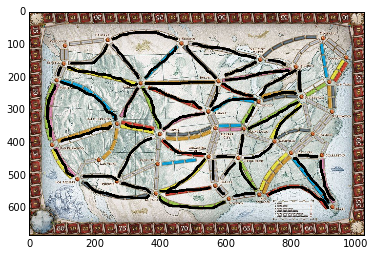

In [11]:
X = cvx.Variable(nmb_c + 2)

f = 0
for i, j in np.ndindex(nmb_c + 2, nmb_c + 2):
    f += U[i, j] * cvx.pos(X[j] - X[i])

objective = cvx.Minimize(f)

constraints = [X >= 0, X <= 1, X[0] == 0, X[-1] == 1]

solution = cvx.Problem(objective, constraints)
solution.solve(solver='GUROBI')

opened_cities = list(np.array(cities)[np.array(X.value).astype(bool)[1:-1].ravel()])
print('Optimal value is: {0}'.format(solution.value))
print("Opened {0} cities: {1}".format(len(opened_cities), opened_cities))

index = [cities.index(city) for city in opened_cities]


year_profit = - open_cost * len(opened_cities)
for i in index:
    for j in index:
        year_profit += profit[i, j] 
print("\n Optimal value of year profit is: {0}".format(year_profit)) 


plt.imshow(mpimg.imread('TicketToRide.png'))
